C:\Users\AnaLeandro\AppData\Local\Temp\ipykernel_48080\15586383.py:99: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(d,s,'b--',color='blue',label='Secant')
C:\Users\AnaLeandro\AppData\Local\Temp\ipykernel_48080\15586383.py:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(d,t,'b--', color = 'red',label='Tangent')


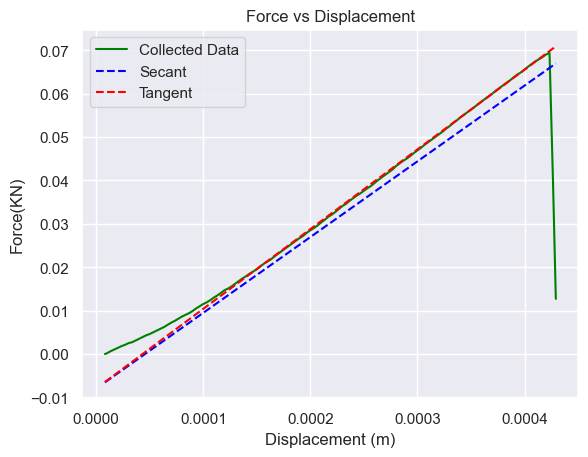

C:\Users\AnaLeandro\AppData\Local\Temp\ipykernel_48080\15586383.py:118: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(d,s,'b--',color='blue',label='Secant')
C:\Users\AnaLeandro\AppData\Local\Temp\ipykernel_48080\15586383.py:119: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(d,t,'b--', color = 'red',label='Tangent')


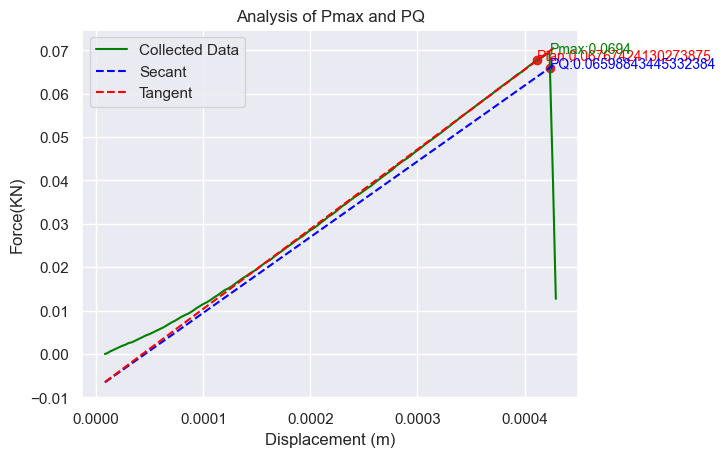

Test is valid because Pmax/PQ <= 1.1
Passed first size requirement check : W ~ 2B
Passed second size requirement check  : a/W is within the range [0.45, 0.55] with tolerance of 0.02.
0.5843177603517627


In [3]:
#Author Ana Leandro apl.web@gmail.com

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
from scipy.stats import linregress
import seaborn as sns
import math
# %matplotlib inline

### Data Import ###

#1st step is to import the csv from the instrument that has all the data
path = input('Please enter the path to file: ')
data = pd.read_csv(path, skiprows=8) # skipping first rows that do not have data


#### Data treatment ####

# Concatanate first row with units to the column name with the measured variable 
columns = data.columns[:3].tolist()
units = data.iloc[0].tolist()
new_columns = [i + j for i, j in zip(columns, units)]
data.columns = new_columns
data=data.drop(data.index[0]) # drop first row with the units since they are already on the column name
data.reset_index(drop=True, inplace=True) # reset index
data=data.astype(float) # convert data from object to float
data['Displacement(mm)']=data['Displacement(mm)']/1000 # convert displacemnt from mm to m 
data = data.rename(columns={'Displacement(mm)':'Displacement(m)'}) # rename column to adjust column unit

# Cloning data to make further analysis.
data_select = data.copy()


#### Data Analysis ####

data_select.drop(['Time(s)'], axis =1, inplace=True) # Dropping the column Time

# Validity Test

#Test 1

# 9.1.1 Load the specimen and obtain a diagram as shown in Fig. 5. 
# Draw a best straight line (AB) to determine the initial compliance, C. C is given by the reciprocal of the slope of line (AB).
# Draw a second line (AB') with a compliance 5 % greater than that of line (AB). If the maximum load that the specimen
# was able to sustain, Pmax, falls within lines (AB) and (AB'), use Pmax to calculate KQ. 
# If Pmax falls outside line (AB) and line (AB'), then use the intersection of line (AB') and the load curve as PQ. 
# Furthermore, if Pmax/PQ < 1.1, use PQ in the calculation of KQ. 
# However, if Pmax/PQ > 1.1, the test is invalid.


#Making a tangent for the linear region of the plot to get the slope

# Define the y values of the two data points you want to use
y1 = 0.02 # Replace with the y value of your first data point
y2 = 0.06 # Replace with the y value of your second data point

# Find the indices of the data points with the closest y values

index1 = (data_select['Force(kN)'] - y1).abs().argmin()
index2 = (data_select['Force(kN)'] - y2).abs().argmin()

# Create a subset of the data containing only those two points
subset_force        = data_select['Force(kN)'][[index1, index2]]
subset_displacement = data_select['Displacement(m)'][[index1, index2]]

# Calculate the regression on the subset of data
slope, intercept, r_value, p_value, std_err = linregress(subset_displacement,subset_force)

#create a function that takes slope and intercept as input to create the regression line
def tangent(x,slope,intercept):
    return x*slope + intercept

# Create a new data series for the tangent data
data_select['Tangent']=data_select['Displacement(m)'].apply(lambda x: tangent(x,slope,intercept))

#Calculate Initial Compliance C
C = 1/slope

# Create a function to calculate the secant (5%higher compliance)
def deviation(x,slope,intercept):
    return x*0.95*slope + intercept

# Create a new data series for the secant data
data_select['Secant']=data_select['Displacement(m)'].apply(lambda x: deviation(x,slope,intercept))


#Plotting the data

F  = data_select['Force(kN)'].array
d  = data_select['Displacement(m)'].array
s  = data_select['Secant'].array
t  = data_select['Tangent'].array

sns.set_theme()

plt.plot(d,F,color ='green',label='Collected Data')
plt.plot(d,s,'b--',color='blue',label='Secant')
plt.plot(d,t,'b--', color = 'red',label='Tangent')
plt.title("Force vs Displacement")
plt.xlabel("Displacement (m)")
plt.ylabel("Force(KN)")
plt.legend()
plt.show()


xi_all, yi_all = mpcalc.find_intersections(d,F,s)
PQ     = float(yi_all[0])
PQ_x   = float(xi_all[0])
Pmax   = max(F)
Pmax_x = data_select['Displacement(m)'][data_select['Force(kN)']==Pmax].values[0]
xj_all, yj_all = mpcalc.find_intersections(d,F,t)
Ptan   = float(yj_all[-1])
Ptan_x = float(xj_all[-1])

plt.plot(d,F,color ='green',label='Collected Data')
plt.plot(d,s,'b--',color='blue',label='Secant')
plt.plot(d,t,'b--', color = 'red',label='Tangent')
plt.scatter(xi_all, yi_all, color='tab:red')
plt.scatter(xj_all[-1], yj_all[-1], color='tab:red')
plt.text(Ptan_x,Ptan, 'Ptan:' + str(Ptan),fontsize=10, color = 'red')
plt.text(Pmax_x,Pmax, 'Pmax:' + str(Pmax),fontsize=10, color = 'green')
plt.text(PQ_x,PQ, 'PQ:' + str(PQ),fontsize=10,color = 'blue')
plt.title("Analysis of Pmax and PQ")
plt.xlabel("Displacement (m)")
plt.ylabel("Force(KN)")
plt.legend()
plt.show()


if Ptan_x < Pmax_x < PQ_x:
    P_chosen = Pmax
else:
    P_chosen = PQ 

# Running the validity test
Ratio_PQ_Pmax = Pmax/PQ
Check_value = 1.1

if Ratio_PQ_Pmax > Check_value:
    print('Test is invalid because Pmax/PQ > 1.1. We will continue analysing the data, but the results are not in accord with ASTM D5045 standards')
else:
    print('Test is valid because Pmax/PQ <= 1.1')

#Test 2

# 9.1.4 For the recommended specimen dimensions of W= 2B and a/W = 0.5, all the relationships of 9.1.3 are satisfied simultaneously. 
# In fact, the criterion covers two limitations in that B must be sufficient to ensure plane strain, but (W−a ) has to be sufficient to avoid excessive plasticity in the ligament. 
# If (W−a) is too small the test will often violate the linearity criteria. 
# If the linearity criterion is violated, a possible option is to increase W for the same a/W and S/W ratios. Values of W/B of up to 4 are permitted
# D5045 says that if the sample was prepared in accord with the standards it is automatically valid for this test.

# Checking size requirements
W = float(input('Enter expected sample height W in cm: '))
B = float(input('Enter expected sample thickness B in cm: '))
a = float(input('Enter expected crack length a in cm: '))
x = a/W

if math.isclose(W,2*B,rel_tol=0.1):
    print('Passed first size requirement check : W ~ 2B')
    if math.isclose(0.45, a/W, rel_tol=0.1) or math.isclose(0.55, a/W, rel_tol=0.1):
        print("Passed second size requirement check  : a/W is within the range [0.45, 0.55] with tolerance of 0.02.")
    else:
        print('''Failed second size requirement check  : a/W is outside the range [0.45, 0.55] with tolerance of 0.02.
You will have to perform a test to collect yield stress. According to ASTM D5045:''')
        
        print('''The yield stress, sigmay, is to be taken from the maximum load in a uniaxial tensile test. 
The yield-stress test can be performed in a constant stroke-rate uniaxial tensile test where the loading time to yield is within +/-20 percent 
of the actual loading time observed in the fracture test. 
The definition of yield stress is not identical to that found in Test Method D638 which requires a zero slope to the stress-strain curve') ''')
else:
    print('''Failed first size requirement check : 2*B is different than W with tolerance of 0.02. 
You will have to perform a test to collect yield stress. According to ASTM D5045:''')
    
    print('''The yield stress, sigmay, is to be taken from the maximum load in a uniaxial tensile test. 
The yield-stress test can be performed in a constant stroke-rate uniaxial tensile test where the loading time to yield is within +/-20 percent 
of the actual loading time observed in the fracture test. 
The definition of yield stress is not identical to that found in Test Method D638 which requires a zero slope to the stress-strain curve') ''')


#### Check Enviroment conditions and crosshead rate ####

# According to ASTM D5045:
# "8.3.1 Since plastics are viscoelastic materials, it is necessary to specify both the temperature and time scale under which the
# result was obtained. As a basic test condition it is recommended that a temperature of 23°C, and a crosshead rate of
# 1.67 × 10−4 m/s (10 mm/min) be used. Record both loading rate and loading time on the report form."

temp = int(input('Enter Temperature of the test in Celsius: '))
crosshead_rate = int(input('Enter crosshead rate of the test in mm/min: '))
relative_humidity = int(input('Enter relative humidity of the test in %: '))


### Calculation on Gic ###

# Due to system compliance, pin penetration and compression effects, it is necessary to determine a displacement or energy correction. This correction will be used to find
# GIc, and is obtained from testing an unnotched sample with the same dimensions as the original sample. The unnotched specimen is loaded up to slightly more load than
# the maximum load of the notched one. Then, the areas under the curves up to PQ in the curves of the notched and unnotched samples (Figure 2.9) are subtracted. 
# That difference is the corrected energy U, used to calculate the critical energy release rate (GIc).

#U = Ui-Uq
#Gic = U/ B*W*f
# whe f is a function of a/W

# It is not possible to directly determine Ui from the notched test data alone. The reason is that Ui is a measure of the energy required to deform the material without causing fracture. 
# In the case of the notched test, the material has already experienced some degree of plastic deformation and the crack has already initiated at the notch tip. Therefore, 
# the energy required to initiate the crack is already included in the total energy absorbed during the test, and it is not possible to separate this contribution from the rest of the 
# energy using only the notched test data.
# One possible way to estimate Ui is to perform additional tests on unnotched specimens under similar loading conditions and use the data from these tests to 
# estimate the energy required for initial deformation. Another option is to use published values of Ui for similar materials under similar loading conditions, although this approach may be less accurate.


### Calculation of Kic ###

# 9.1 Interpretation of Test Record and Calculation of KQ—In order to establish that a valid KIc has been determined, it is first  necessary to calculate a conditional result, KQ, which involves a construction on the test record, and to then determine whether  this result is consistent with the size of the specimen in
# accordance with 9.1.3. The procedure is given in 9.1.1 – 9.1.5.
# If sample passes recommended size criteria and no further yield test is required KQ is equal to KIc. Otherwise the test is not a valid KIc test. 

######## Attention to units ###########

# Q = load as determined in 9.1.1, kN,
# B = specimen thickness as determined in 8.2.1, cm,
# W = specimen depth (width) as determined in 8.2.3, cm, and
# a = crack length as determined in 8.2.2, cm.
# x =a/W

# KQ in units of MPa · m ^1/2 

fx = 6*math.sqrt(x)*(1.99-x*(1-x)*(2.15-3.93*x+2.7*(x**2)))/(1+2*x)*(1-x)**(3/2)

# Choose P
Kq = (P_chosen/B*math.sqrt(W))*fx
print(Kq)



#### Generating a report ####

dict_results = {'specimen_depth(cm)':W,
'specimen thickness(cm)': B,
'crack length(cm)': a,
'PQ(kN)': PQ,
'Pmax(kN)': Pmax,
'f(a/W)': fx,
'Kq(MPa*m^(1/2)': Kq,
'Testing Temperature_(C)': temp,
'Crosshead rate(mm/min)': crosshead_rate,
'Relative humidity(%)': relative_humidity
}

results = pd.DataFrame(dict_results, index = [0])

results.to_csv('Report.csv')




##### END OF CODE #####





# # dimensions-- from ASTM D5045
# W = float(0.01);      # height of sample in meters
# B = (W/2);            # thickness of part in meters
# length = (2*(2.2*W)); # total length of part in meters
# a = 0.5/1000;            # crack length 
# x = a/W